In [ ]:
!pip3 install transformers

In [ ]:
!pip3 install d2l

In [1]:
import torch
import torch.nn as nn
import os 
import random
from d2l import torch as d2l
from torch.utils.data import Dataset,DataLoader
from typing import List, Optional, Tuple, Union
import math
from torch._C import dtype
import time
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.tensorboard import SummaryWriter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Datasets

In [2]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

In [3]:
def _read_wiki(data_dir):
  file_name = os.path.join(data_dir, 'wiki.train.tokens')
  with open(file_name, 'r') as f:
    lines = f.readlines()
  paragraphs = [line.strip().lower().split(' . ')
                for line in lines if len(line.split(' . ')) >= 2]
  random.shuffle(paragraphs)
  return paragraphs
  

## next sentence Predict task

In [4]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
  if random.random()<0.5:
    is_next = True
  else:
    # paragraphs是三重列表的嵌套
    next_sentence = random.choice(random.choice(paragraphs))
    is_next = False
  return sentence, next_sentence, is_next

In [5]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
  """
  获取输入序列的词元及其段索引
  """
  tokens = ['<cls>'] + tokens_a + ['<sep>']
  #0和1分别表示标记段A和B
  segments = [0]* (len(tokens_a) + 2)
  if tokens_b is not None:
    tokens += tokens_b + ['<sep>']
    segments += [1]* (len(tokens_b) + 1 )
  return tokens, segments

In [6]:
def  _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
  nsp_data_from_paragraph = []
  for i in range(len(paragraph)-1):
    tokens_a, tokens_b, is_next = _get_next_sentence(paragraph[i], paragraph[i+1],paragraphs)
    #考虑一个'<cls>'词和两个'<sep>'词
    if len(tokens_a) + len(tokens_b) + 3 > max_len:
      continue
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    nsp_data_from_paragraph.append((tokens, segments, is_next))
  return nsp_data_from_paragraph

## mask language model task

In [7]:
def _replace_mlm_tokens(tokens, candiate_pred_positions, num_mlm_preds, vocab):
  #为掩码语言模型的输入创建新的词元副本，其中输入可能包含替换的'<mask>'词元或随机词元
  mlm_input_tokens = [token for token in tokens]
  pred_positions_and_labes = []
  #打乱后用于在掩码语言模型中获取15%的随即词元进行预测
  random.shuffle(candiate_pred_positions)
  for mlm_pred_position in candiate_pred_positions:
    if len(pred_positions_and_labes) >= num_mlm_preds:
      break
    masked_token = None
    #80%的时间，将词元替换为'<mask>'词元
    if random.random() < 0.8:
      masked_token = '<mask>'
    else:
      #10%的概率保持词元不变
      if random.random() < 0.5:
        masked_token = tokens[mlm_pred_position]
      else:
        #10%概率，用随机词元替换
        masked_token = random.choice(vocab.idx_to_token)
    mlm_input_tokens[mlm_pred_position] = masked_token
    pred_positions_and_labes.append((mlm_pred_position, tokens[mlm_pred_position]))
  return mlm_input_tokens, pred_positions_and_labes

In [8]:
def _get_mlm_data_from_tokens(tokens,vocab):
  candiate_pred_positions = []
  #tokens是一个字符串列表
  for i, token in enumerate(tokens):
    #剔除掉特殊词元
    if token in ['<cls>', '<sep>']:
      continue
    candiate_pred_positions.append(i)
  #预测15%得随机词元
  num_mlm_preds = max(1, round(len(candiate_pred_positions) * 0.15))
  mlm_input_tokens, pred_positions_and_labes = _replace_mlm_tokens(tokens, candiate_pred_positions,
                                                                   num_mlm_preds, vocab)
  pred_positions_and_labes = sorted(pred_positions_and_labes,
                                    key = lambda x: x[0])
  pred_positions = [v[0] for v in pred_positions_and_labes]
  mlm_pred_labels = [v[1] for v in pred_positions_and_labes]
  return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]


## build datasets

In [9]:
def _pad_bert_inputs(examples, max_len, vocab):
  max_num_mlm_preds = round(max_len*0.15)
  all_tokens_ids, all_segments, attention_mask = [], [], []
  all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
  nsp_labels = []
  for (token_ids, pred_positions, mlm_pres_label_ids, segments, is_next) in examples:
    all_tokens_ids.append(torch.tensor(token_ids +  [vocab['<pad>']] * (max_len - len(token_ids)),dtype=torch.long).to(device))
    all_segments.append(torch.tensor(segments + [0] * (max_len - len(segments)),dtype=torch.long).to(device))
    #attention_mask不包括pad的计数
    attention_mask.append(torch.tensor([1] *len(token_ids) + [0] * (max_len - len(token_ids)),dtype=torch.float32).to(device))
    all_pred_positions.append(torch.tensor(pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)),dtype=torch.long).to(device))
    #填充词元的预测将通过乘以权重seita在损失中过滤掉
    all_mlm_weights.append(torch.tensor([1.0] * len(pred_positions) + [0.0] * (max_num_mlm_preds - len(pred_positions)),dtype=torch.float32).to(device))
    all_mlm_labels.append(torch.tensor(mlm_pres_label_ids +[0]*(max_num_mlm_preds - len(mlm_pres_label_ids)), dtype=torch.long).to(device))
    nsp_labels.append(torch.tensor(is_next, dtype=torch.long).to(device))
  return (all_tokens_ids, all_segments, attention_mask, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)

In [10]:
class _WikiTextDataset(Dataset):
  def __init__(self, paragraphs, max_len):
    super().__init__()
    """
    输入paragraphs[i]是代表段落的句子字符串列表
    而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
    """
    paragraphs = [d2l.tokenize(paragraph, token = 'word') for paragraph in paragraphs]
    sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
    self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=['<pab>', '<mask>', '<cls>', '<sep>'])
    #获取下一句预测任务的数据
    examples = []
    for paragraph in paragraphs:
      examples.extend(_get_nsp_data_from_paragraph(paragraph,paragraphs,self.vocab,max_len))
    #获取掩码语言模型的任务的数据
    examples = [(_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next)) for tokens,segments,is_next in examples]
    #填充输入
    (self.all_tokens_ids, self.all_segments, self.attention_mask, self.all_pred_positions, self.all_mlm_weights, self.all_mlm_labels,
     self.nsp_labels) = _pad_bert_inputs(examples,max_len,self.vocab)

  def __getitem__(self, idx):
    return (self.all_tokens_ids[idx], self.all_segments[idx], self.attention_mask[idx], self.all_pred_positions[idx], self.all_mlm_weights[idx], self.all_mlm_labels[idx],
     self.nsp_labels[idx])
    
  def __len__(self):
    return len(self.all_tokens_ids)  

In [11]:
def load_data_wiki(batch_size,max_len):
  num_workers = d2l.get_dataloader_workers()
  data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
  paragraphs = _read_wiki(data_dir)
  train_set = _WikiTextDataset(paragraphs,max_len)
  train_iter = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  return train_iter, train_set, train_set.vocab


# build model

## 1.embedding

In [12]:
class bertEmbedding(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.wordEmbedding = nn.Embedding(config.vocab_size,config.hidden_size)
    self.token_type_Embedding = nn.Embedding(config.type_vocab_size, config.hidden_size)
    self.position_Embedding = nn. Embedding(config.max_position_embeddings, config.hidden_size)
    
    self.position_ids = torch.arange(config.max_position_embeddings).expand((1,-1)).to(device)

    self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    

  def forward(self, input_ids, token_type_ids):
    wordEmbedding = self.wordEmbedding(input_ids)
    token_type_Embedding = self.token_type_Embedding(token_type_ids)
    position_embedding = self.position_Embedding(self.position_ids)

    embedding = wordEmbedding + token_type_Embedding + position_embedding

    embedding = self.LayerNorm(embedding)

    embedding = self.dropout(embedding)

    return embedding
   

## 2.encoder

### selfAttention

In [13]:
class bertSelfAttention(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.num_attention_heads = config.num_attention_heads
    self.attention_head_size = int(config.hidden_size/config.num_attention_heads)
    self.all_head_size = self.num_attention_heads * self.attention_head_size

    self.query = nn.Linear(config.hidden_size, self.all_head_size)
    self.key = nn.Linear(config.hidden_size, self.all_head_size)
    self.value = nn.Linear(config.hidden_size, self.all_head_size)

    self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

  def transpose_for_scores(self, x:torch.Tensor) -> torch.Tensor:
    '''
    shape 64 * 128 * 768 -->64 * 128 * 12 * 64 --> 64 * 12 * 128 *64
    '''
    new_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
    x = x.view(new_shape)
    x = x.permute(0,2,1,3)
    return x 

  def forward(self, hidden_states:torch.Tensor, attention_mask:torch.Tensor, output_attention: Optional[bool] = False) -> Tuple[torch.Tensor]:

    query_layer = self.query(hidden_states)
    key_layer = self.key(hidden_states)
    value_layer = self.value(hidden_states)

    query_layer = self.transpose_for_scores(query_layer)# 64 * 12 * 128 *64
    key_layer = self.transpose_for_scores(key_layer)# 64 * 12 * 128 *64
    value_layer = self.transpose_for_scores(value_layer)# 64 * 12 * 128 *64

    attention_scores = torch.matmul(query_layer,key_layer.transpose(2,3))/math.sqrt(config.hidden_size)
    #64 * 12 * 128 * 128 
    #attention_mask 64 * 128
    mask_scores = torch.zeros(attention_mask.size(0), self.num_attention_heads, attention_mask.size(1),  attention_mask.size(1)).to(device)
    mask_scores += attention_mask[:,None,None,:]#自动广播
    mask_scores = (1 - mask_scores)* torch.finfo().min

    attention_scores = attention_scores + mask_scores

    attention_probs = nn.functional.softmax(attention_scores, dim = -1)
    attention_probs = self.dropout(attention_probs)

    context_layer = torch.matmul(attention_probs, value_layer) # 64 * 12 * 128 *64

    context_layer = context_layer.permute(0,2,1,3).contiguous().view(hidden_states.size(0),hidden_states.size(1),-1)
    
    outputs = (context_layer, attention_probs) if output_attention else (context_layer,)

    return outputs


In [14]:
class bertSelfOutput(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.LayerNorm = nn.LayerNorm(config.hidden_size,eps=config.layer_norm_eps)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self, hidden_states:torch.Tensor, input_tensor:torch.Tensor)-> torch.Tensor:
    hidden_states = self.dense(hidden_states)
    hidden_states = self.dropout(hidden_states)
    hidden_states = self.LayerNorm(hidden_states + input_tensor)
    return hidden_states

In [15]:
class bertAttention(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.selfAttention = bertSelfAttention(config)
    self.output = bertSelfOutput(config)

  def forward(self,hidden_states:torch.Tensor, attention_mask:torch.Tensor, output_attention:Optional[bool] = False) -> Tuple[torch.Tensor]:
    selfoutput = self.selfAttention(hidden_states, attention_mask, output_attention)
    outputs = self.output(selfoutput[0], hidden_states)
    outputs = (outputs,) + selfoutput[1:]
    return outputs


### FFN

In [16]:
class bertIntermediate(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
    self.act = nn.GELU()

  def forward(self,hidden_states:torch.Tensor) ->torch.Tensor:
    hidden_states = self.dense(hidden_states)
    hidden_states = self.act(hidden_states)
    return hidden_states

In [17]:
class InterOutput(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.dense = nn.Linear(config.intermediate_size,config.hidden_size)
    self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self,hidden_states:torch.Tensor, input_tensor:torch.Tensor)->torch.Tensor:
    hidden_states = self.dense(hidden_states)
    hidden_states = self.dropout(hidden_states)
    hidden_states = self.LayerNorm(hidden_states + input_tensor)
    return hidden_states

In [18]:
class FFN(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.Intermediate = bertIntermediate(config)
    self.InterOutput = InterOutput(config)

  def forward(self, hidden_states:torch.Tensor) -> torch.Tensor:
    Intermediate = self.Intermediate(hidden_states)
    FFNoutput = self.InterOutput(Intermediate, hidden_states)
    return FFNoutput

### bertLayer

In [19]:
class bertLayer(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.attention = bertAttention(config)
    self.FFN = FFN(config)

  def forward(self, hidden_states:torch.Tensor, attention_mask:torch.Tensor, output_attention:Optional[bool] = False) -> Tuple[torch.Tensor]:
    self_attention_output = self.attention(
        hidden_states,
        attention_mask,
        output_attention
    )
    
    attention_output_state = self_attention_output[0]
    attention_output_prob = self_attention_output[1:]

    layer_output = self.FFN(attention_output_state)

    outputs = (layer_output,) + attention_output_prob
    return outputs 

### encoder

In [20]:
class bertEncoder(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.config = config
    self.layer = nn.ModuleList([bertLayer(config) for _ in range(config.num_hidden_layers)])



  def forward(self,
              hidden_states:torch.Tensor,
              attention_mask:torch.Tensor,
              output_attentions: Optional[bool] = False,
              output_hidden_states: Optional[bool] = False
              )-> Tuple[torch.Tensor]:


              all_hidden_states = () if output_hidden_states else None
              all_self_attentions = () if output_attentions else None


              for i ,layer_module in enumerate(self.layer):
                if output_hidden_states:
                  all_hidden_states = all_hidden_states + (hidden_states,)


                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    output_attentions
                )
                hidden_states = layer_outputs[0]

                if output_attentions:
                  all_self_attentions = all_self_attentions + (layer_outputs[1],)

              if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)
              
              return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)


## 3.pooler

In [21]:
class bertPooler(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.dense = nn.Linear(config.hidden_size,config.hidden_size)
    self.act = nn.Tanh()


  def forward(self, hidden_states:torch.Tensor) -> torch.Tensor:
      pooloutput = self.dense(hidden_states[:,0])
      pooloutput = self.act(pooloutput)
      return pooloutput


## 4.bertmodel

In [22]:
class bertmodel(nn.Module):
  def __init__(self, config, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.config = config
    self.embedding = bertEmbedding(config)
    self.encoder = bertEncoder(config)
    self.pool = bertPooler(config)


  def forward(self, input_ids:torch.Tensor, token_type_ids:torch.Tensor, attention_mask:torch.Tensor, output_attentions: Optional[bool] = False,
              output_hidden_states: Optional[bool] = False)->tuple[torch.Tensor]:

              embedding_output = self.embedding(input_ids,token_type_ids)
              encoder_output = self.encoder(embedding_output, attention_mask, output_attentions = output_attentions, output_hidden_states = output_hidden_states)
              sequence_output = encoder_output[0]
              pooled_output = self.pool(sequence_output)

              return (sequence_output, pooled_output,) + encoder_output[1:]

# pretrained task

## 1.mask language model

In [23]:
class MaskLM(nn.Module):
  def __init__(self, config,  *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.mlp = nn.Sequential(
        nn.Linear(config.hidden_size, config.hidden_size),
        nn.ReLU(),
        nn.LayerNorm(config.hidden_size,eps=config.layer_norm_eps),
        nn.Linear(config.hidden_size,config.vocab_size)
    )

  def forward(self, encoder_states:torch.Tensor, pred_positions:torch.Tensor)->torch.Tensor:
      num_pred_positions = pred_positions.shape[1] #19
      pred_positions = pred_positions.view(-1)# 64*19的向量
      batch_size = encoder_states.shape[0] #64
      batch_idx = torch.arange(0, batch_size) #19
      '''
      这里是要实现这样一个事情，把num_pred_positions这个64*19的tensor拉成一个向量
      这个向量的前19个元素是第一个batch里的预测的位置，之后是19个是第二个batch里的预测位置 。。。。
      但是现在的batch_idx是这样的一个tensor([0,0,0,...,0,1,1,....,1,2,2,......])
      '''
      batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
      masked = encoder_states[batch_idx, pred_positions]
      masked = masked.view((batch_size, num_pred_positions,-1))
      mlm_pred = self.mlp(masked)
      return mlm_pred


## 2.next sentence predict

In [24]:
class NextSentencePred(nn.Module):
  def __init__(self, config,  *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.output = nn.Linear(config.hidden_size, 2)

  def forward(self, pooler_output:torch.Tensor)->torch.Tensor:
    '''
    pooler_output 为 64 * 768 的tensor
    '''
    return self.output(pooler_output)

# bertLanguageModel


In [25]:
class bertLanguageModel(nn.Module):
  def __init__(self, config,  *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.bert = bertmodel(config)
    # 输出encoder_states 64*128*768 和 pooler 64*768
    self.mlm = MaskLM(config)
    #输出 64*19*vocab_size
    self.nsp = NextSentencePred(config)
    #输出 64*2

  def forward(self, input_ids:torch.Tensor, token_type_ids:torch.Tensor, attention_mask:torch.Tensor,  pred_positions:torch.Tensor, output_attentions: Optional[bool] = False,
              output_hidden_states: Optional[bool] = False) -> tuple[torch.Tensor]:
    encoder_states = self.bert(input_ids, token_type_ids, attention_mask, output_attentions, output_hidden_states)
    encoder_seq = encoder_states[0]
    pooler_output = encoder_states[1]
    mlm_pred = self.mlm(encoder_seq, pred_positions)
    nsp_pred = self.nsp(pooler_output)

    return (encoder_seq, mlm_pred, nsp_pred)


# train

## loss function

In [26]:
def _get_batch_loss(loss, mlm_pred, nsp_pred, mlm_weights, mlm_l, nsp_l, config):
  '''
  mlm_pred 64*19*vocab_size
  mlm_l 64*19
  mlm_weights 64*19
  nsp_pred 64*2
  nsp_l 64
  注意我们这里使用的交叉熵reduction参数要加none 不能自动求均值，因为mask还有padding需要处理
  加了参数reduction='none'后loss不会自动求均值，而是会返回每个位置的损失，返回一个tensor向量，大小为64*19
  这时，将mlm_weights view成一个64*19的一维tensor也就是向量，做向量点乘(不是内积)，返回一个64*19的向量，这时这个向量
  的padding部分已经和0相乘变成0，在对tensor求和求均值
  或者可以直接用torch.matmul() 如果传入两个tensor都是一维向量，则会做向量内积，返回一个标量 scaler 这个就是对padding处理后的真实损失，直接求均值即可
  '''

  mlm_loss = loss(mlm_pred.view(-1,config.vocab_size), mlm_l.view(-1)) * mlm_weights.view(-1)  #mask掉padding的预测位置
  mlm_loss = mlm_loss.sum() / (mlm_weights.sum() + 1e-8) #加1e-8 做偏差修正，防止除数为0，常规操作

  nsp_loss = loss(nsp_pred,nsp_l)
  nsp_loss = nsp_loss.sum() / (nsp_loss.shape[0]) 

  loss = nsp_loss + mlm_loss
  return (loss, nsp_loss, mlm_loss)

## train function

In [27]:
def train_bert(dataloader, model, optim, loss, config, device, SummaryWriter):
  mlm_loss_sum = []
  nsp_loss_sum = [] 
  sentence_pair_sum = []
  batch_sum = [] 
  total_time = [] 
  
  input_ids_w = torch.ones(config.batch_size, config.max_len, dtype=torch.long).to(device)
  token_type_id_w = torch.ones(config.batch_size, config.max_len, dtype=torch.long).to(device)
  attention_w = torch.ones(config.batch_size, config.max_len, dtype=torch.float32).to(device)
  pred_positions_w = torch.ones(config.batch_size,round(config.max_len*0.15), dtype=torch.long).to(device)

  SummaryWriter.add_graph(model, (input_ids_w, token_type_id_w, attention_w, pred_positions_w))

  for epoch in range(config.epochs):
    fig, ax = plt.subplots()
    mlm_loss_current_epoch = []
    nsp_loss_current_epoch = []
    sentence_pair_current_epoch = 0
    batch_current_epoch = 0
    total_time_current_epoch = 0
    with open(f'./{epoch}.txt', 'w') as f:
      for input_ids, token_type_ids, attention_mask, pred_positions, mlm_weights, mlm_l, nsp_l in dataloader:
        optim.zero_grad()
        start_time = time.time()
        encoder_states = model(input_ids, token_type_ids, attention_mask, pred_positions)
        mlm_pred = encoder_states[1]
        nsp_pred = encoder_states[2]
        loss_ = _get_batch_loss(loss, mlm_pred, nsp_pred, mlm_weights, mlm_l, nsp_l, config)
        mlm_loss = loss_[2]
        nsp_loss = loss_[1]
        loss_sum = loss_[0]
        loss_sum.backward()
        optim.step()

        SummaryWriter.add_scalar('mlm_loss', mlm_loss, epoch * len(dataloader) + batch_current_epoch)
        SummaryWriter.add_scalar('nsp_loss', nsp_loss, epoch * len(dataloader) + batch_current_epoch)
        SummaryWriter.add_scalar('lr', optim.param_groups[0]['lr'], epoch * len(dataloader) + batch_current_epoch)

        mlm_loss_current_epoch.append(mlm_loss.cpu().detach().numpy())
        nsp_loss_current_epoch.append(nsp_loss.cpu().detach().numpy())
        sentence_pair_current_epoch += input_ids.shape[0]
        batch_current_epoch += 1
        end_time = time.time()
        current_batch_time = end_time - start_time
        total_time_current_epoch += current_batch_time
        ax.cla()
        ax.plot(mlm_loss_current_epoch, label='mlm_loss')
        ax.plot(nsp_loss_current_epoch, label='nsp_loss')
        ax.legend()
        ax.set_title(f'epoch {epoch} Losses')
        ax.set_xlabel('Batch')
        ax.set_ylabel('Loss')
        ax.set_xlim(0, len(dataloader))
        display.display(fig)
        display.clear_output(wait=True)
      
      
        log = f'currrent_batch_mlm_loss {mlm_loss:.3f}  ' f'currrent_batch_nsp_loss {nsp_loss:.3f}  ' \
              f'{input_ids.shape[0] / current_batch_time:.2f}  '  'sentence pairs /sec on  ' f'{str(device)}  '  \
              f'{current_batch_time:2f}  '  ' sec elapsed in current batch' f'{batch_current_epoch}  ' + '\n'
        f.write(log)
     
  
      plt.savefig(f'./{epoch}.jpg')
      plt.close() 
    
    
      
      log = f'epoch {epoch} MLM LOSS {sum(mlm_loss_current_epoch) / batch_current_epoch:.3f}  ' \
            f'NSP LOSS {sum(nsp_loss_current_epoch) / batch_current_epoch:.3f}  ' \
            f'{sentence_pair_current_epoch / total_time_current_epoch:.1f}  '   'sentences pairs/sec on  ' f'{str(device)}  ' \
            f'{total_time_current_epoch:2f} sec elapsed in current epoch  ' f'{epoch}  ' + '\n'      
      f.write(log)
      f.close()
    
    SummaryWriter.add_histogram('wordEmbedding', model.bert.embedding.wordEmbedding.weight, epoch)
    SummaryWriter.add_histogram('mlm_output', model.mlm.mlp[3].weight, epoch)
    mlm_loss_sum.append(mlm_loss_current_epoch)
    nsp_loss_sum.append(nsp_loss_current_epoch)
    sentence_pair_sum.append(sentence_pair_current_epoch)
    batch_sum.append(batch_current_epoch)
    total_time.append(total_time_current_epoch)
  torch.save(model.bert, '/root/code/HuggingFaceTransformer/model/bert.bin')
    

# begin train

In [28]:
class config():
  def __init__(self):
    self.vocab_size = 20256
    self.hidden_size = 768
    self.type_vocab_size = 2
    self.max_position_embeddings = 128
    self.layer_norm_eps = 1e-12
    self.hidden_dropout_prob = 0.1
    self.num_attention_heads = 12
    self.attention_probs_dropout_prob = 0.1
    self.intermediate_size = 3072
    self.num_hidden_layers = 12
    self.batch_size = 64
    self.max_len = 128
    self.epochs = 5

config = config()

In [29]:
Dataloader, Dataset, vocab = load_data_wiki(config.batch_size,config.max_len)

In [30]:
model = bertLanguageModel(config).to(device)

In [32]:
loss = nn.CrossEntropyLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [33]:
SummaryWriter = SummaryWriter(log_dir='./', comment='bert')

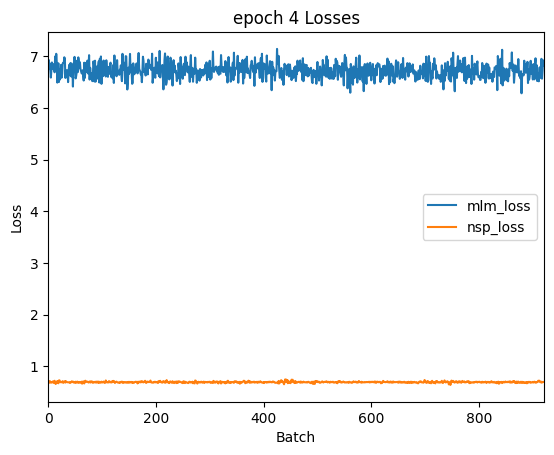

In [35]:
train_bert(Dataloader, model, optim, loss, config, device, SummaryWriter)